# Construisez un modèle de scoring

## Introduction

<div>
    <img src="attachment:047468cf-6efb-4420-806c-4a155f3a7a3e.png" width="500"/>
</div>

**Mon rôle:** Data Scientist  
**Nom de la société**: Prêt à dépenser  
**Service de la société**: Propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.

**Mission**: Aider à décider si un prêt peut être accordé à un client.  
Mettre en œuvre un algorithme de classification de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non.  
Puis classifie la demande : crédit accordé ou refusé.

**Utilisateurs**: Chargés de relation client.

**Remarques**: Le modèle doit être facilement interprétable et doit disposer d’une mesure de l’importance des variables pour définir la probabilité.

---

**Fichiers d'entrée**:
- [10 fichiers CSV](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip)
- [Explication de chaque fichier](https://www.kaggle.com/c/home-credit-default-risk/data)
- [Description des colonnes](../input/HomeCredit_columns_description.csv)

## Importation des différents fichiers

In [102]:
from helpers import *

Regardons nos fichiers disponibles:

In [103]:
pd.DataFrame(os.listdir("../input/data/"), columns=["Nom des fichiers"])

,Nom des fichiers
0,application_test.csv
1,HomeCredit_columns_description.csv
2,POS_CASH_balance.csv
3,credit_card_balance.csv
4,installments_payments.csv
5,application_train.csv
6,bureau.csv
7,.ipynb_checkpoints
8,previous_application.csv
9,bureau_balance.csv


- [Description des fichiers](https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook#Data)
- [Description de chaque colonne](./../input/HomeCredit_columns_description.csv)

---

On va se concentrer sur **2 fichiers** qui contiennent le plus de données pour commencer:
- application_test.csv
- application_train.csv

On remarque que le fichier **application_train.csv** est le seul à avoir la colonne TARGET.  
Quand la valeur = 1, le client a eu des difficultés de paiement.  
Quand la valeur = 0, le client n'a pas eu de difficulté.

C'est ce qu'on va chercher à prédire dans les 2 fichiers.

In [104]:
# Load the 2 files
app_train = pd.read_csv('../input/data/application_train.csv')
app_test = pd.read_csv('../input/data/application_test.csv')

print('Shape', app_train.shape)

Shape (307511, 122)


Parmis les colonnes existantes, je préfère retirer toute colonnes qui ne sont pas éthiques pour éviter de potentiel bias dans les résultats.  
Je les retire des 2 fichiers.

In [105]:
# Removing unethical columns to remove bias
unethical_columns = [
    "CODE_GENDER", # Gender of the client
    "DAYS_BIRTH", # Client's age in days at the time of application
]

# Dropping unethical columns
app_train.drop(columns=unethical_columns, inplace=True)
app_test.drop(columns=unethical_columns, inplace=True)

app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

J'observe les types de mes différentes variables.

In [106]:
app_train.dtypes.value_counts()

float64    65
int64      40
object     15
dtype: int64

In [107]:
app_train.shape

(307511, 120)

Je remarque que j'ai 15 colonnes de type object, je vais surement devoir les encoder en fonction du nombre de valeurs unique.  
Je vais déjà stocker les colonnes de chaque type dans des variables différentes.

In [108]:
col_type_int64 = app_train.select_dtypes('int64').columns
col_type_float64 = app_train.select_dtypes('float64').columns
col_type_object = app_train.select_dtypes('object').columns

J'affiche les valeurs manquantes pour chaque type.

### Inspection du type Int64

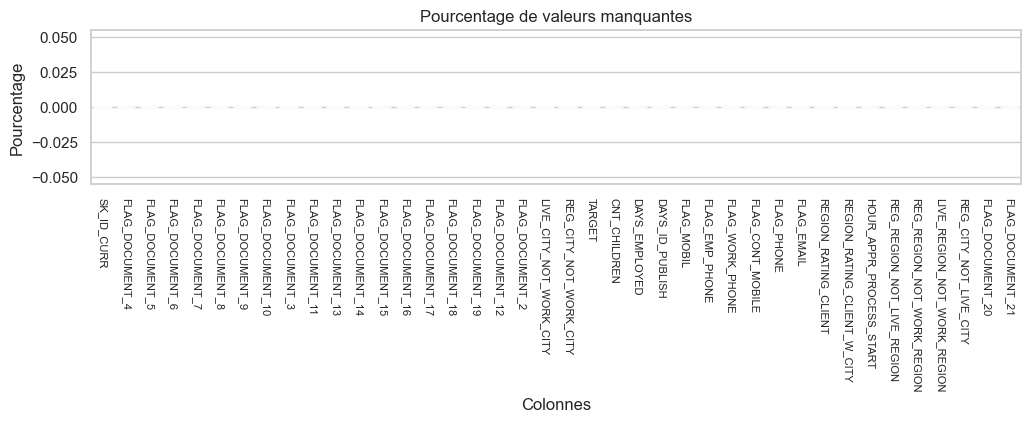

In [109]:
display_percentage_missing_chart(app_train[col_type_int64], 1)

Pas de valeurs manquantes pour les colonnes de type int64, je vais regarder les outliers

In [110]:
# Checking outliers for int64
pd.set_option("display.max_columns", None)
app_train[col_type_int64].describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,63815.045904,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335
std,102790.175348,0.272419,0.722121,141275.766519,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299
min,100002.000000,0.000000,0.000000,-17912.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,-2760.000000,-4299.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,-1213.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367142.500000,0.000000,1.000000,-289.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000,2.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,1.000000,19.000000,365243.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


J'observe que les colonnes DAYS_EMPLOYED et DAYS_ID_PUBLISH on des valeurs négatives.
Concernant le reste, c'est souvent binaire.

Pour rappel des descriptions:  
	- **DAYS_EMPLOYED**   = `How many days before the application the person started current employment`  
 	- **DAYS_ID_PUBLISH** = `How many days before the application did client change the identity document with which he applied for the loan`

Pour DAYS_EMPLOYED, j'affiche un graphique de distribution des jours employés

#### Résultat

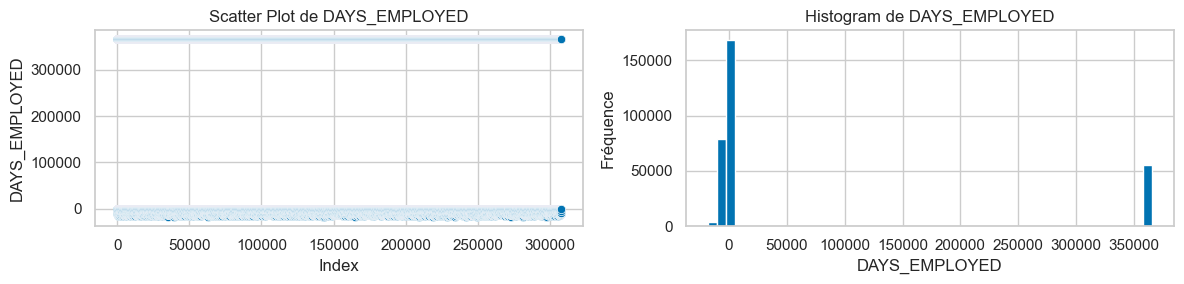

In [111]:
display_scatter_and_hist_graph_for_column(app_train,"DAYS_EMPLOYED")

Je remarque que +50k valeurs sont égales à 365243.  
Ça m'a l'air d'être une erreur, on ne peut pas être employé 1000ans après avoir fait le demande de crédit, lors de la demande.  
Dans ce cas, je vais les remplacer par NaN pour continuer mon analyse sans bias.

In [112]:
app_train[app_train['DAYS_EMPLOYED'] >= 0]['DAYS_EMPLOYED'].value_counts()
print(f"DAYS_EMPLOYED a {app_train['DAYS_EMPLOYED'].isna().sum()} valeurs NaN")

app_train['DAYS_EMPLOYED'].replace({365243: np.NaN}, inplace = True)
app_test['DAYS_EMPLOYED'].replace({365243: np.NaN}, inplace = True)

# app_train['DAYS_EMPLOYED'].replace({365243: -1}, inplace = True)
# app_train['DAYS_EMPLOYED'].replace({365243: 0}, inplace = True)

print(f"DAYS_EMPLOYED a maintenant {app_train['DAYS_EMPLOYED'].isna().sum()} valeurs NaN")

DAYS_EMPLOYED a 0 valeurs NaN
DAYS_EMPLOYED a maintenant 55374 valeurs NaN


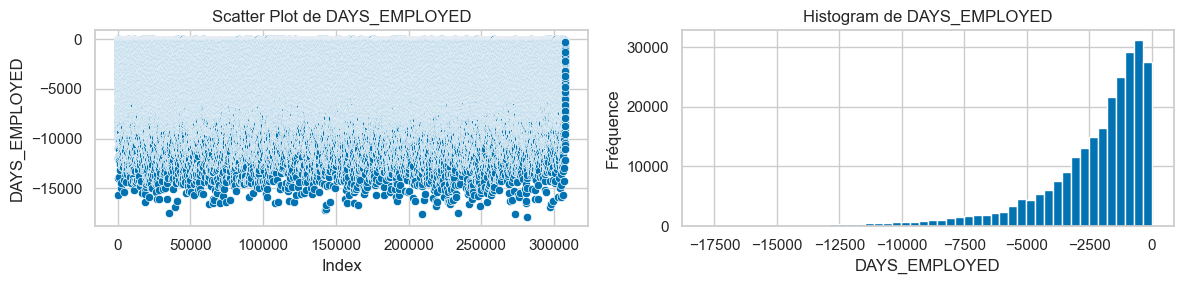

In [113]:
display_scatter_and_hist_graph_for_column(app_train,"DAYS_EMPLOYED")

Ok ça me parait mieux pour effectuer mon analyse et feature engineering.  
Je vais maintenant observer l'autre colonne DAYS_ID_PUBLISH

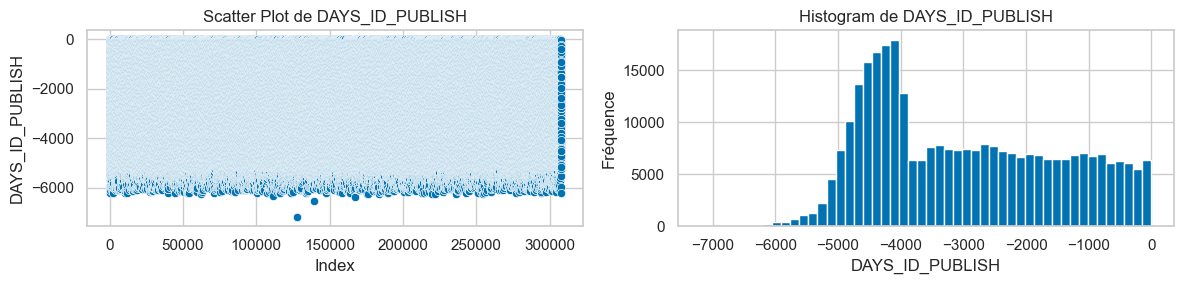

In [114]:
display_scatter_and_hist_graph_for_column(app_train,"DAYS_ID_PUBLISH")

Pas de valeurs positives, ça me rassure.

### Inspection du type Object

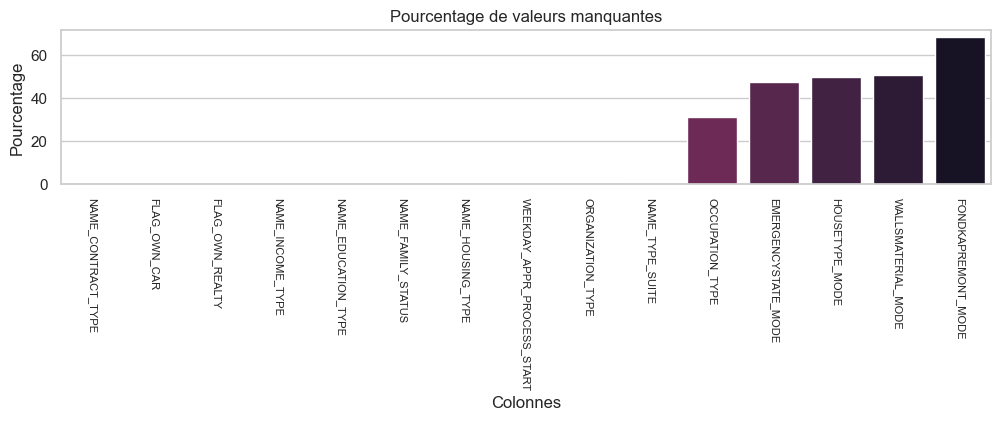

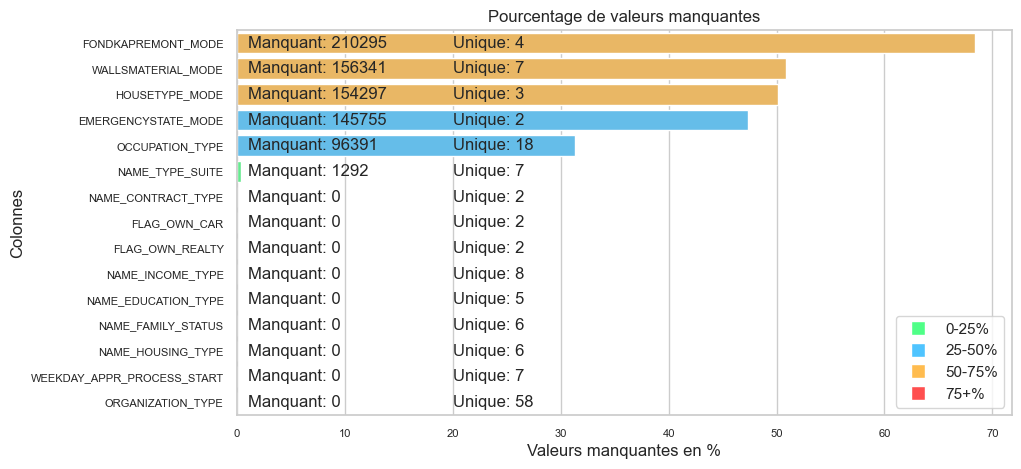

In [115]:
display_percentage_missing_chart(app_train[col_type_object], 1)
display_graph_missing_data(app_train[col_type_object], 5)

Dans ce cas de figure, n'ayant peu de colonnes unique je vais transdformer les colonnes de type object en int64 afin de pouvoir les étudier. 

Je vais utiliser deux méthodes comme défini dans le [kaggle d'exemple fourni](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction): 

- **Label Encoder** : Pour les colonnes qui n'ont que 2 valeurs (afin d'avoir un 1 ou 0),
- **One-Hot encoding**: Pour les colonnes qui ont plus que 2 valeurs, créer une colonnes en plus par valeur unique.

In [116]:
# Label encode object (<= unique type > Label encoder
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # print(
        unique_vals = list(app_train[col].unique())
                 
        if len(unique_vals) <= 2.0:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col].map(lambda x: x if x in unique_vals else np.nan))
            app_test[col] = le.transform(app_test[col].map(lambda x: x if x in unique_vals else 0))
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d colonnes transformées avec la méthode "label encoded".' % le_count)

3 colonnes transformées avec la méthode "label encoded".


In [117]:
# One-hot encoding for feature with > 2 unique values
print('app_train avant one-hot encoding: ', app_train.shape)
print('app_test avant one-hot encoding: ', app_test.shape)

# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('\napp_train après one-hot encoding: ', app_train.shape)
print('app_test après one-hot encoding: ', app_test.shape)

app_train avant one-hot encoding:  (307511, 120)
app_test avant one-hot encoding:  (48744, 119)

app_train après one-hot encoding:  (307511, 239)
app_test après one-hot encoding:  (48744, 236)


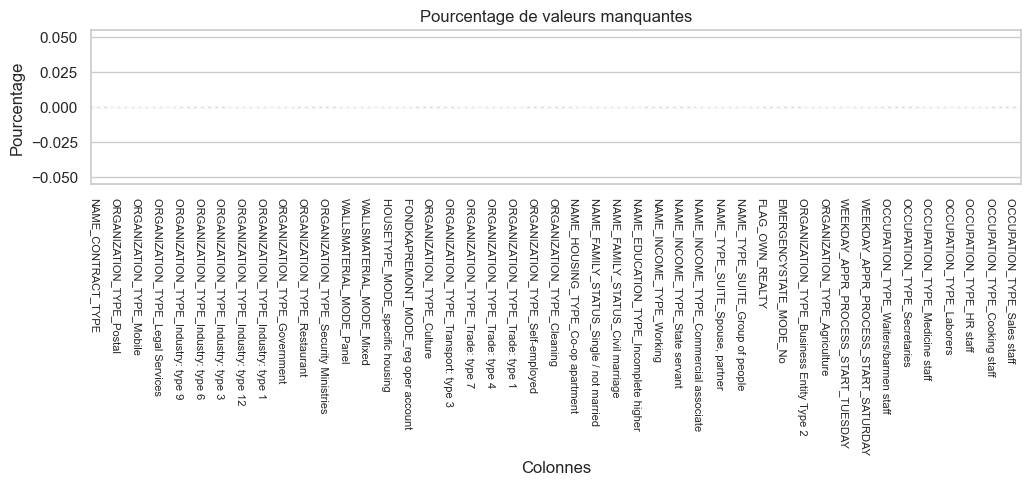

In [118]:
test_data = app_train.drop(columns=col_type_int64).drop(columns=col_type_float64)
display_percentage_missing_chart(test_data, 3)

Comme prévu, pas de valeurs manquantes.

### Inspection du type Float64

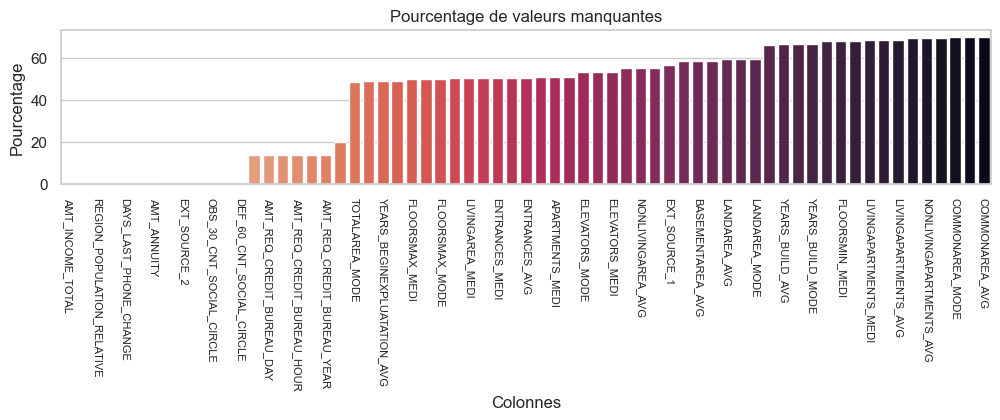

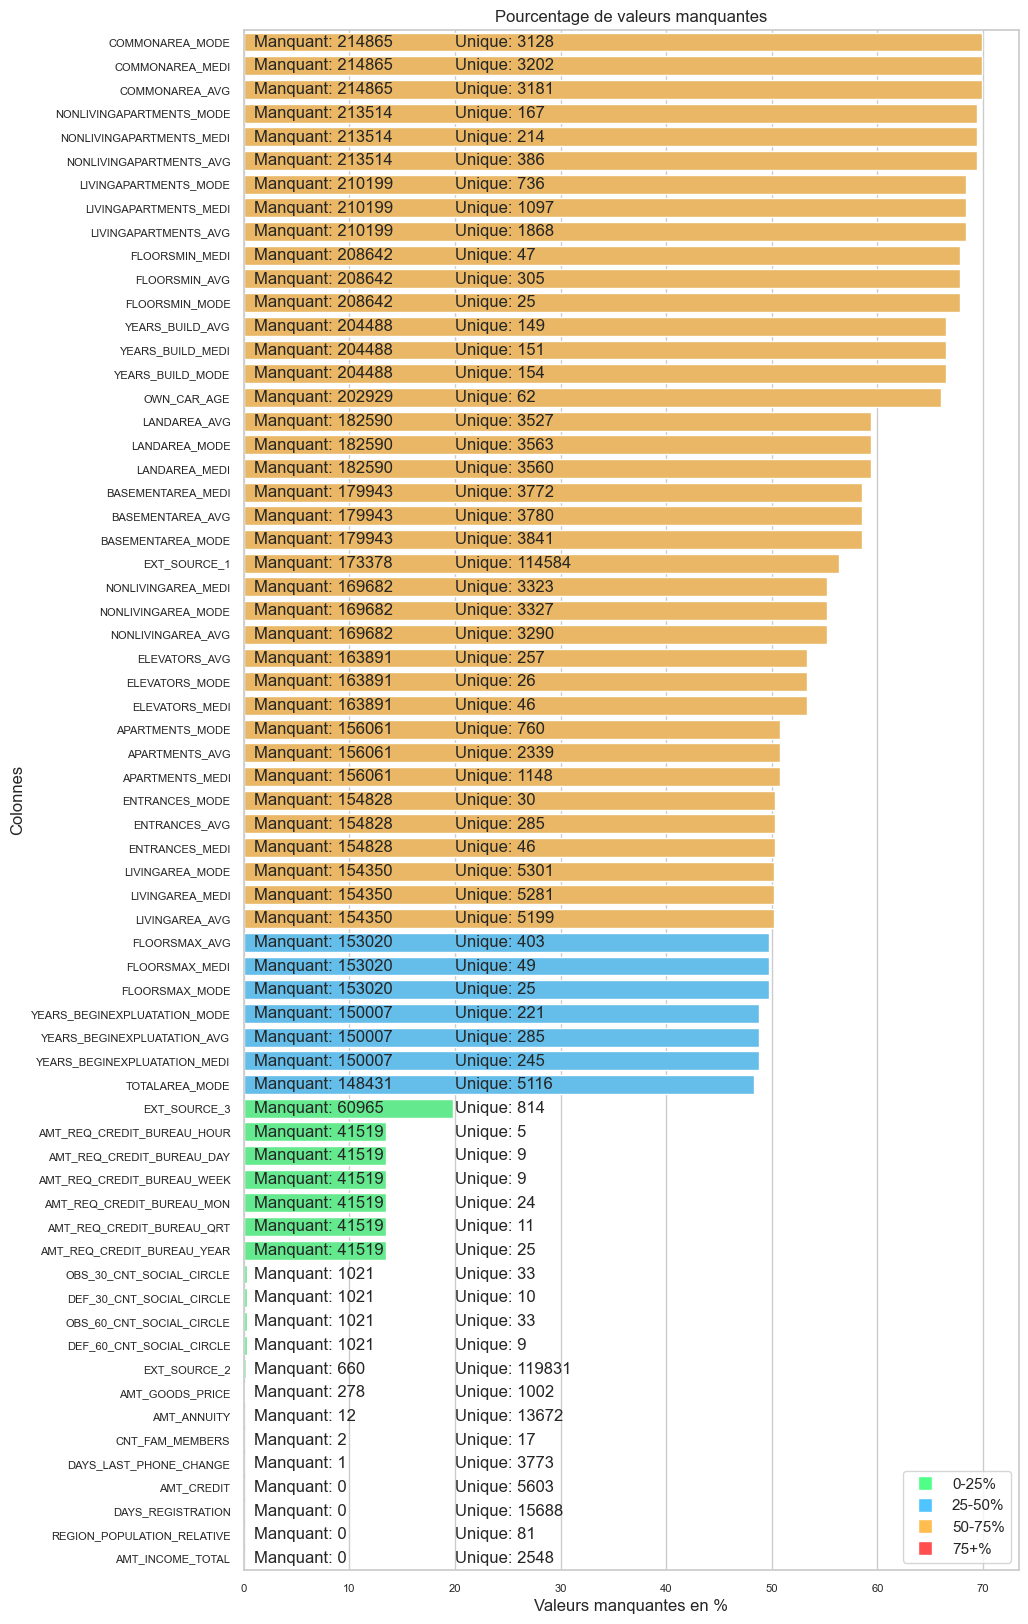

In [119]:
display_percentage_missing_chart(app_train[col_type_float64], 2)
display_graph_missing_data(app_train[col_type_float64], 20)

Beaucoup de valeurs manquantes.  
Je commence par observer les valeurs abérrantes

In [120]:
app_train[col_type_float64].describe()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,104582.000000,307509.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-4986.120328,12.061091,2.152665,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.977752,0.755746,0.044595,0.078078,0.149213,0.225897,0.231625,0.067169,0.101954,0.108607,0.008651,0.028236,0.102547,1.422245,0.143421,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,3522.886321,11.944812,0.910682,0.211062,1.910602e-01,0.194844,0.10824,0.082438,0.059223,0.113280,0.076036,0.134576,0.100049,0.144641,0.161380,0.081184,0.092576,0.110565,0.047732,0.069523,0.107936,0.084307,0.064575,0.110111,0.074445,0.132256,0.100977,0.143709,0.161160,0.081750,0.097880,0.111845,0.046276,0.070254,0.109076,0.082179,0.059897,0.112066,0.076144,0.134467,0.100368,0.145067,0.161934,0.082167,0.093642,0.112260,0.047415,0.070166,0.107462,2.400989,0.446698,2.379803,0.362291,826.808487,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-24672.000000,0.000000,1.000000,0.014568,8.173617e-08,0.000527,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.125000e+05,2.700000e+05,16524.000000,2.3

Je ne vois pas de valeurs abérrantes, je vais continuer pas observer de features puis je remplacerai les valeurs manquantes

### Observation des features pertinentes

Pour améliorer la detection de correlations et les entrainements de modèles, je vais normaliser les features dans un autre tableau. (Détails dans la description des colonnes)

Je vais maintenant remplacer les valeurs manquantes par différentes méthodes pour analyser le meilleur comportement.
- Suppression total des valeurs manquantes
- Remplacement des valeurs manquantes par la moyenne
- Remplacement des valeurs manquantes par la médiane
- Remplacement des valeurs manquantes par 0

Je vérifie maintenant les correlations entre les features pour voir si je peux réduire en dimension mon dataframe.

#### Résultat

#### Corrélations avec TARGET

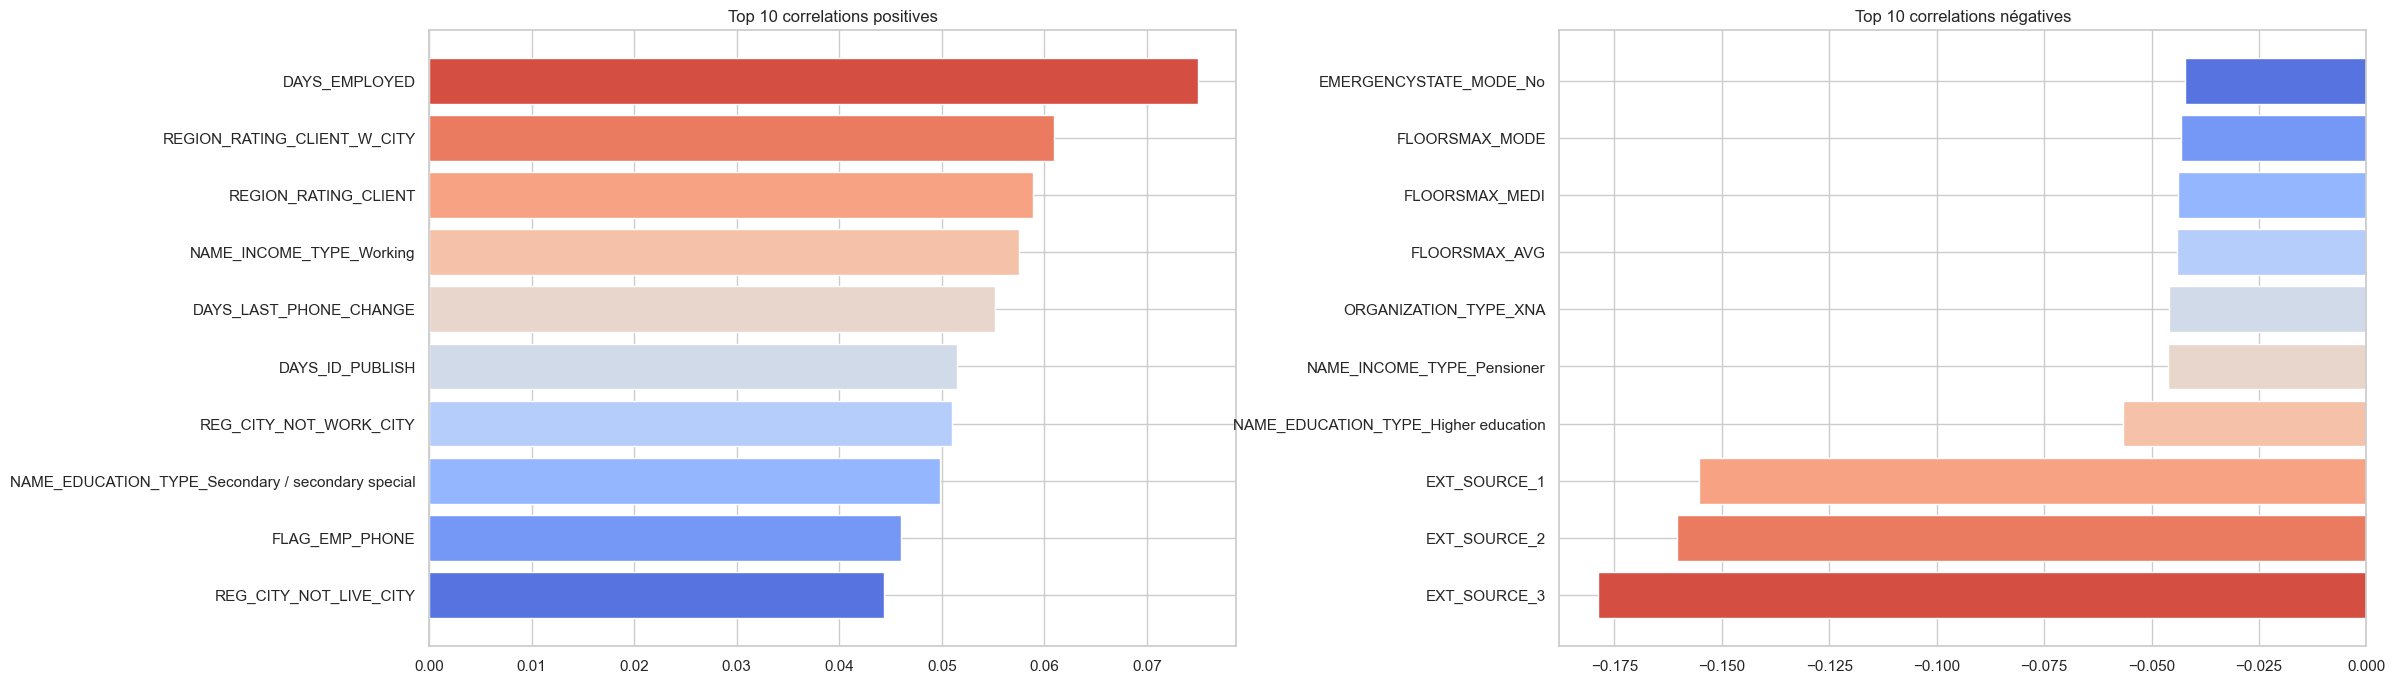

In [121]:
corr = get_target_correlations(app_train)

In [122]:
app_train.shape

(307511, 239)

In [123]:
df_functions = {  
    "sum_living_features": test_sum_living_features,  
    "sum_flag_documents": test_sum_flag_documents,  
    "sum_flag_contacts": test_sum_flag_contacts,
    "sum_flag_living_contact": lambda df: test_sum_flag_contacts(test_sum_flag_documents(test_sum_living_features(df)))  
}

all_data = {}

all_data["default"] = {}  
all_data["default"]["df"] = app_train.copy()
all_data["default"]["test_df"] = app_test.copy()
print(f"Dataframe default shape = {all_data['default']['df'].shape}")
    
for df_name, func in df_functions.items():  
    all_data[df_name] = {}  
    all_data[df_name]["df"] = func(app_train)  
    all_data[df_name]["test_df"] = func(app_test)  
    print(f"Dataframe {df_name} shape = {all_data[df_name]['df'].shape}")

Dataframe default shape = (307511, 239)
Dataframe sum_living_features shape = (307511, 197)
Dataframe sum_flag_documents shape = (307511, 220)
Dataframe sum_flag_contacts shape = (307511, 234)
Dataframe sum_flag_living_contact shape = (307511, 173)


In [124]:
corr_sum_living_features = get_target_correlations(all_data["sum_living_features"]["df"], False)
corr_sum_flag_documents = get_target_correlations(all_data["sum_flag_documents"]["df"], False)
corr_sum_flag_contacts = get_target_correlations(all_data["sum_flag_contacts"]["df"], False)

In [125]:
print("Correlation sum_living_features: ", corr_sum_living_features["sum_living_features"]["TARGET"])
print("Correlation sum_flag_documents: ", corr_sum_flag_documents["sum_flag_documents"]["TARGET"])
print("Correlation sum_flag_contact: ", corr_sum_flag_contacts["sum_flag_contacts"]["TARGET"])

Correlation sum_living_features:  -0.04630944359839301
Correlation sum_flag_documents:  0.017193412923494727
Correlation sum_flag_contact:  0.02077352046541818


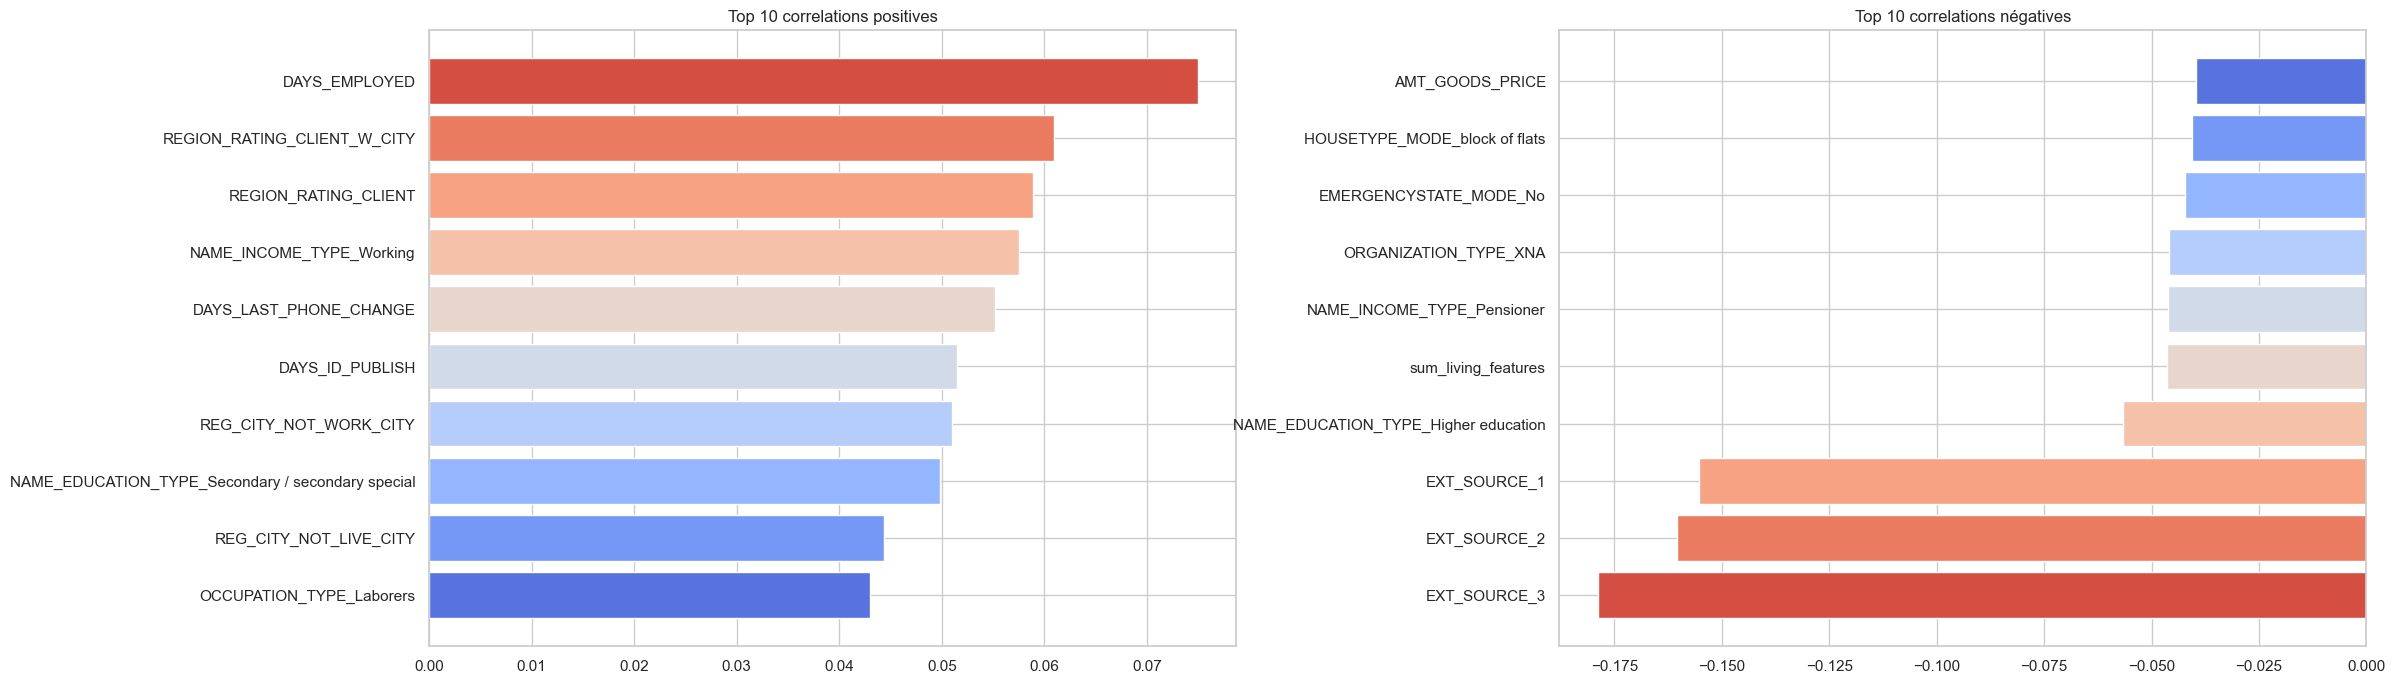

In [126]:
corr_sum_flag_living_contact = get_target_correlations(all_data["sum_flag_living_contact"]["df"])

#### Mutual informations

In [127]:
mi_scores_default = make_mi_scores_class(all_data["default"]["df"].drop("TARGET", axis=1), all_data["default"]["df"]["TARGET"])
mi_scores_sum_flag_living_contact = make_mi_scores_class(all_data["sum_flag_living_contact"]["df"].drop("TARGET", axis=1), all_data["sum_flag_living_contact"]["df"]["TARGET"])

In [ ]:
fix, axs = plt.subplots(2, 1, figsize=(15, 10))
plot_mi_scores(mi_scores_default[:20],axs[0],"Mutual Information Scores (default)")
plot_mi_scores(mi_scores_sum_flag_living_contact[:20], axs[1],"Mutual Information Scores (flag, living, contact)")

In [ ]:
show_feature_balance(app_train["TARGET"])

In [ ]:
print(f"Dataframe before undersampling, good client: {len(app_train[app_train['TARGET'] == 0])} bad client: {len(app_train[app_train['TARGET'] == 1])}")
app_train = undersample_dataframe(app_train, "TARGET")
print(f"Dataframe after undersampling, good client: {len(app_train[app_train['TARGET'] == 0])} bad client: {len(app_train[app_train['TARGET'] == 1])}")
show_feature_balance(app_train["TARGET"])

### Feature Engineering

Prepare all models

In [ ]:
# Copying the data because the normalization will add more keys
copied_all_data = all_data.copy()

# Loop trhough all and normalize them
for data_name in copied_all_data.keys():
    print(f"Normalizing {data_name} dataframes (per columns & all columns)...")

    # Data that won't be normalized
    target = all_data[data_name]["df"]["TARGET"].copy()
    ident = all_data[data_name]["df"]["SK_ID_CURR"].copy()
    test_ident = all_data[data_name]["test_df"]["SK_ID_CURR"].copy()

    # Per columns
    norm_col_name = f"{data_name}_norm_col"
    all_data[norm_col_name] = {}
    all_data[norm_col_name]["df"] = normalize_per_col(all_data[data_name]["df"].drop(columns=["TARGET", "SK_ID_CURR"]))
    all_data[norm_col_name]["test_df"] = normalize_per_col(all_data[data_name]["test_df"].drop(columns=["SK_ID_CURR"]))
    
    all_data[norm_col_name]["df"].insert(all_data[data_name]["df"].columns.get_loc(ident.name), ident.name, ident)
    all_data[norm_col_name]["df"].insert(all_data[data_name]["df"].columns.get_loc(target.name), target.name, target)
    all_data[norm_col_name]["test_df"].insert(all_data[data_name]["test_df"].columns.get_loc(test_ident.name), test_ident.name, test_ident)
    
    
    # All columns
    norm_all_name = f"{data_name}_norm_all"
    all_data[norm_all_name] = {}
    all_data[norm_all_name]["df"] = normalize_all_col(all_data[data_name]["df"].drop(columns=["TARGET", "SK_ID_CURR"]))
    all_data[norm_all_name]["test_df"] = normalize_all_col(all_data[data_name]["test_df"].drop(columns=["SK_ID_CURR"]))

    all_data[norm_all_name]["df"].insert(all_data[data_name]["df"].columns.get_loc(ident.name), ident.name, ident)
    all_data[norm_all_name]["df"].insert(all_data[data_name]["df"].columns.get_loc(target.name), target.name, target)
    all_data[norm_all_name]["test_df"].insert(all_data[data_name]["test_df"].columns.get_loc(test_ident.name), test_ident.name, test_ident)
    

print("Done")

In [ ]:
all_data["default_norm_all"]["df"].head()

In [ ]:
all_data["default_norm_col"]["df"].head()

In [ ]:
all_data["default"]["df"].head()

In [ ]:
# Prepare all dataFrames for feature engineering
for data_name in all_data.keys():
    print(f"Preparing {data_name}...")
    all_data[data_name] = prepare_dataFrame_for_feature_engineering(all_data[data_name])
print("Done")

In [ ]:
all_data["default"]["df"].head()

In [ ]:
all_data["default_norm_col"]["df"].head()

In [ ]:
all_data["default_norm_all"]["df"].head()

---

#### BASELINE

In [ ]:
all_data["sum_living_features_norm_all"]["y_train"].head(10)

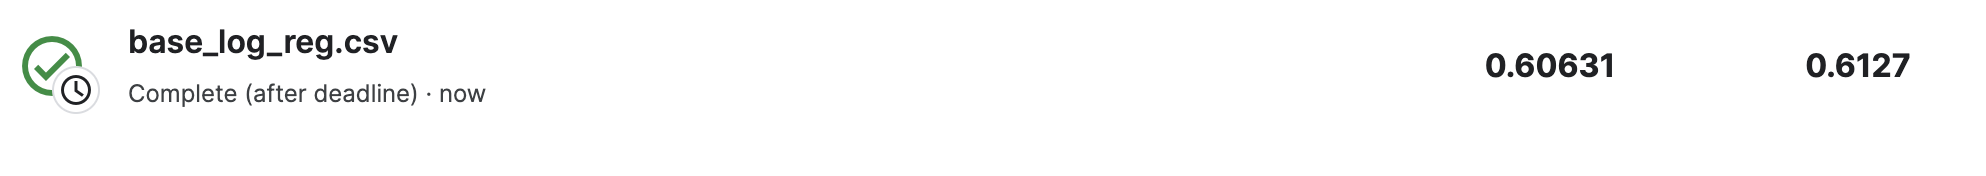

In [ ]:
# create_baseline(all_model["base"], "rf_classifier",rf_class, "base")


In [ ]:
for data_name in all_data.keys():
    log_reg = LogisticRegression(C = 0.0001,solver='lbfgs', max_iter=1000, verbose=0)
    create_baseline(all_data[data_name], "log_reg",log_reg, data_name)

In [ ]:
# create_baseline(all_model["base"], "rf_classifier",rf_class, "base")

for data_name in all_data.keys():
    rf_class = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose=0, n_jobs=6)
    create_baseline(all_data[data_name], "rf_class",rf_class, data_name)

In [ ]:
all_data["default"]["df_aligned"].shape
# all_data["default"]["rf_class"].feature_importances_.shape

In [ ]:
check_feature_importances(all_data["default"]).head(10)

In [ ]:
check_feature_importances(all_data["default"]).head(10)

In [ ]:
check_feature_importances(all_data["sum_flag_living_contact"]).head(10)

In [ ]:
check_feature_importances(all_data["sum_flag_living_contact_norm_col"]).head(10)

In [ ]:
check_feature_importances(all_data["sum_flag_living_contact_norm_all"]).head(10)

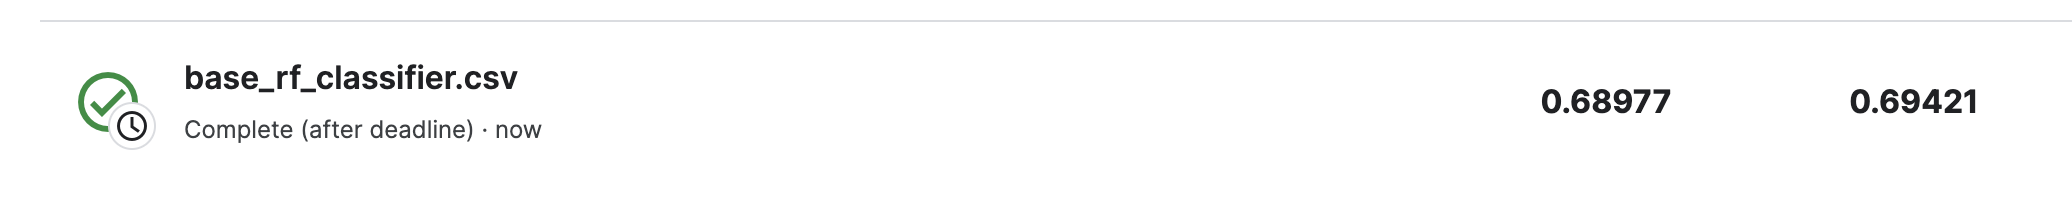

In [ ]:
for data_name in all_data.keys():
    xgb_class = XGBClassifier(random_state=0)
    create_baseline(all_data[data_name], "xgb_class",xgb_class, data_name)

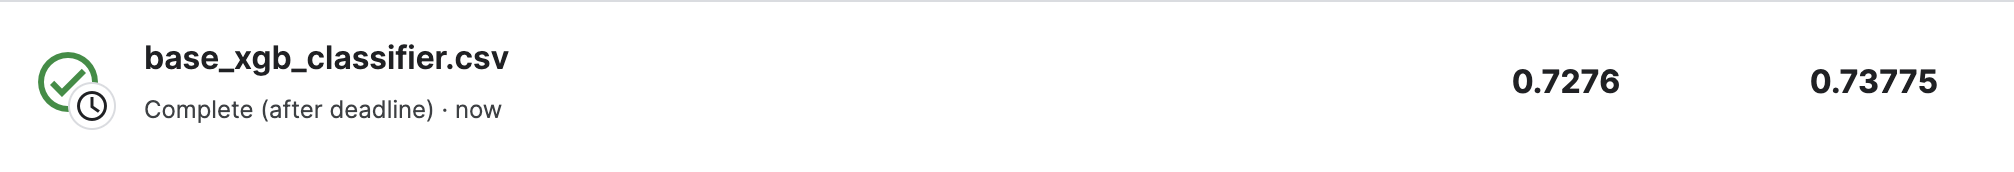

In [ ]:
for data_name in all_data.keys():
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(len(all_data[data_name]["X_train"].columns),))
    ])

    nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    create_baseline(all_data[data_name], "nn_model",nn_model, data_name)

In [ ]:
kaggle_results = pd.read_csv("./submissions/result.txt")
model_names = ["log_reg", "xgb_class", "rf_class"]
# model_names = ["log_reg", "xgb_class", "rf_class", "nn_model"]

# Initialize empty lists for data  
data = { 'name': [] }
data_2d_local = { 'name': [], "mse":[] }
data_2d_kaggle = { 'name': [], "score":[] }

local_cols = []
kaggle_cols = []


# Print DataFrame
for data_name in all_data.keys():
    
    data["name"].append(data_name)
    
    for model_name in model_names:
        mse = all_data[data_name][f"{model_name}_mse"]
        key = f"local_{model_name}"
        kkey = f"kaggle_{model_name}"
        
        if key not in data:
            local_cols.append(key)
            data[key] = []
        
        if kkey not in data:
            kaggle_cols.append(kkey)
            data[kkey] = []
        
        
        data[key].append(mse)
        kaggle_score = kaggle_results[kaggle_results["fileName"] == f"{data_name}_{model_name}.csv"]["privateScore"].values[0]
        data[kkey].append(kaggle_score)
        
        data_2d_local["name"].append(f"{data_name}_{model_name}")
        data_2d_local["mse"].append(mse)
        
        data_2d_kaggle["name"].append(f"{data_name}_{model_name}")
        data_2d_kaggle["score"].append(kaggle_score)

stats = pd.DataFrame(data)
stats = stats.reset_index(drop=True)

data_2d_local = pd.DataFrame(data_2d_local)
data_2d_kaggle = pd.DataFrame(data_2d_kaggle)


In [ ]:
local_cols

In [ ]:
stats.head(15)

In [ ]:
show_graph_kaggle(stats[kaggle_cols], data_2d_kaggle)

In [ ]:
show_graph_local(stats[local_cols], data_2d_local)
# show_graph_local(stats[stats["local_nn_model"] < 0.5][local_cols], data_2d_local)

---

In [ ]:
print(f"Good customer = {len(app_train[app_train['TARGET'] == 0])}")
print(f"Bad customer = {len(app_train[app_train['TARGET'] == 1])}")

In [ ]:

print(f"Good customer = {len(all_data['default']['df'][all_data['default']['df']['TARGET'] == 0])}")
print(f"Bad customer = {len(all_data['default']['df'][all_data['default']['df']['TARGET'] == 1])}")


In [ ]:
# Keeping sum_living_features_xgb_class


In [ ]:
dataFrame = all_data['sum_living_features']
xgb_class = XGBClassifier(random_state=0)

param_grid = {  
    'max_depth': [3, 5, 7],  
    'learning_rate': [0.01, 0.1, 0.5],  
    'n_estimators': [100, 500, 1000]  
}
grid_search = GridSearchCV(estimator=xgb_class,scoring='neg_mean_squared_error', param_grid=param_grid, cv=3)  
grid_search.fit(dataFrame["X_train"],dataFrame["y_train"])  


In [ ]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best params: {best_params}")
print(f"Best score: {-best_score}")

In [ ]:
# dataFrame = all_data['sum_living_features']

xgb_class = XGBClassifier(random_state=0, **best_params)

create_baseline(dataFrame, "xgb_class_best",xgb_class, 'sum_living_features')

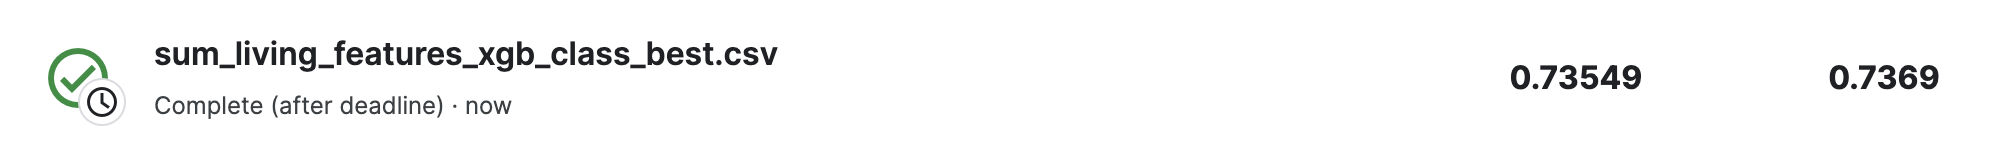

In [ ]:
dataFrame["xgb_class_best_local_proba"][:5]

In [ ]:
dataFrame["xgb_class_best_pred"][:5]

In [ ]:
fn, fp, tp, tn = get_false_negatives_false_positives(dataFrame["y_test"], dataFrame["xgb_class_best_pred"])
print(tp, fp)
print(fn, tn)

In [ ]:
dataFrame['local_test'] = np.where(dataFrame['xgb_class_best_local_proba'] > 0.269, 1, 0)
dataFrame['local_test'][:5]

In [ ]:
fn, fp, tp, tn = get_false_negatives_false_positives(dataFrame["y_test"], dataFrame["local_test"])
print(tp, fp)
print(fn, tn)

avg_credit = 1
# avg_credit = app_train["AMT_CREDIT"].mean()

cost_fp = fp * avg_credit
cost_fn = fn * avg_credit * 10

print(f"Credit moyen: {avg_credit:.2f}")
print(f"Cout Faux Negatif: {cost_fn:.2f}")
print(f"Cout Faux Positif: {cost_fp:.2f}")

print(mean_squared_error(dataFrame["local_test"], dataFrame["y_test"]))


In [ ]:
# Create dataframe for costs  
costs = pd.DataFrame({'Type': ['Faux Négatif', 'Faux Positif'],  
                      'Cost': [cost_fn, cost_fp]})  
  
# Create bar plot  
sns.barplot(x='Type', y='Cost', data=costs)  
plt.xlabel('Type')  
plt.ylabel('Cost')  
plt.title('Costs')  
plt.show()  

In [ ]:
cost_fps = []  
cost_fns = [] 

thresholds = np.arange(0, 1, 0.001)
lowest_cost = float("inf")
best_threshold = None

for threshold in thresholds:
    dataFrame['local_test'] = np.where(dataFrame['xgb_class_best_local_proba'] > threshold, 1, 0)  
    fn, fp, tp, tn = get_false_negatives_false_positives(dataFrame["y_test"], dataFrame["local_test"])  

    c_fp = fp * avg_credit
    c_fn = fn * avg_credit * 10
    
    cost_fps.append(c_fp)  
    cost_fns.append(c_fn)  

    if abs(c_fp - c_fn) < lowest_cost:
        lowest_cost = abs(c_fn - c_fp)
        best_threshold = threshold

plt.plot(thresholds, cost_fps, label='FP (Bon client prédit mauvais)')  
plt.plot(thresholds, cost_fns, label='FN (Mauvais client prédit bon)')  
plt.xlabel('Threshold')  
plt.ylabel('Cost')  
plt.legend()

# Find the index of the threshold at which the two lines cross  
crossing_threshold_index = np.argmin(np.abs(np.array(cost_fns) - np.array(cost_fps)))  
crossing_threshold = thresholds[crossing_threshold_index]  

# Add the crossing point to the graph
plt.scatter(crossing_threshold, cost_fps[crossing_threshold_index], color='red', label='Crossing Point')  
print(best_threshold)
plt.show()  

In [ ]:
# Create dataframe for costs  
costs = pd.DataFrame({'Type': ['Faux Négatif', 'Faux Positif'],  
                      'Cost': [cost_fn, cost_fp]})  
  
# Create bar plot  
sns.barplot(x='Type', y='Cost', data=costs)  
plt.xlabel('Type')  
plt.ylabel('Cost')  
plt.title('Costs')  
plt.show()

In [ ]:
crossing_threshold

In [ ]:
best_params

In [ ]:
# Plot feature importance
xgb_plot_importance(
    booster=dataFrame["xgb_class_best"],
    max_num_features=20,
)
fig = plt.gcf()
fig.set_size_inches(20, 10)


# Plot tree
xgb_plot_tree(booster=dataFrame["xgb_class_best"], rankdir="LR")
fig = plt.gcf()
fig.set_size_inches(100, 50)


In [ ]:
print(f"True value = {dataFrame['y_test'].iloc[68]}")


In [ ]:
print(f"True value = {dataFrame['y_test'].iloc[68]}")
check_sample(dataFrame, 23).show_in_notebook()

In [ ]:
print(f"True value = {dataFrame['y_test'].iloc[5]}")
check_sample(dataFrame,5).show_in_notebook()

# random_sample = 120
# found = True
# while found:
#     exp = check_sample(random_sample)
#     if(exp.predict_proba[1] >= 0.3 and all_data['sum_living_features']['y_test'].iloc[random_sample] == 1):
#         found = False
#         print(f"True value ({random_sample}) = {all_data['sum_living_features']['y_test'].iloc[random_sample]}")
#         exp.show_in_notebook()
#     random_sample +=1
    

In [ ]:
# Weigh accuracy (scorer between 0 and 100)